Enter starting room name/number:  C12
Enter destination room name/number:  C22


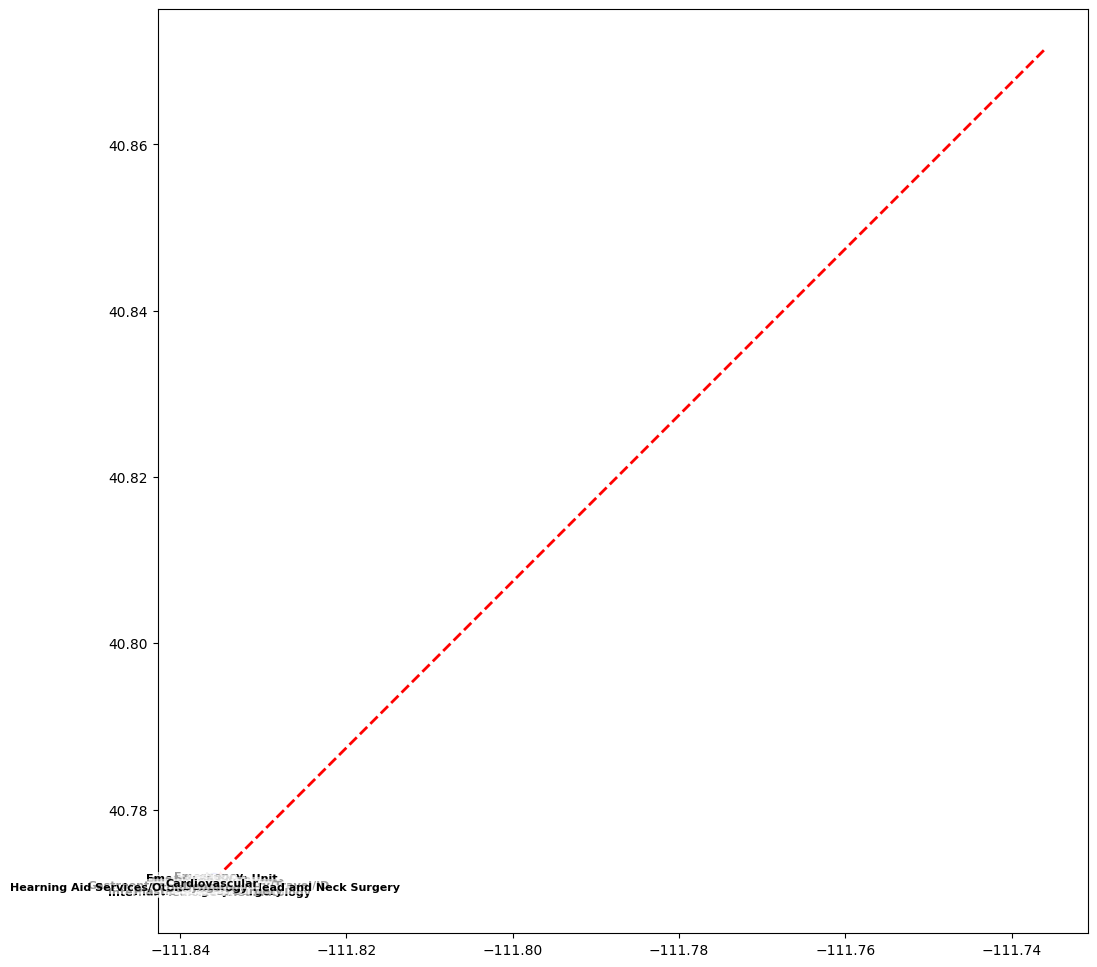

In [13]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt 
import shapely.geometry
from shapely.geometry import LineString,Point
import networkx as nx 

gdf_1=gpd.read_file("Level_1_final_final_final.geojson")
gdf_2=gpd.read_file("Level_2.geojson")
room_type="Room Type"
room_no="Room No"

rooms_1=gdf_1[~gdf_1[room_type].str.startswith("c",na=False)]
corridors_1=gdf_1[gdf_1[room_type].str.startswith("c",na=False)]
rooms_2=gdf_2[~gdf_2[room_type].str.startswith("c",na=False)]
corridors_2=gdf_2[gdf_2[room_type].str.startswith("c",na=False)]

rooms=pd.concat([rooms_1,rooms_2],ignore_index=True)
corridors=pd.concat([corridors_1,corridors_2],ignore_index=True)

start_room=input("Enter starting room name/number: ").strip()
end_room=input("Enter destination room name/number: ").strip()

start_geom=rooms[(rooms[room_type]==start_room)|(rooms[room_no]==start_room)].geometry
end_geom=rooms[(rooms[room_type]==end_room)|(rooms[room_no]==end_room)].geometry

if start_geom.empty or end_geom.empty:
    raise ValueError("One of the rooms not found in data!")
    
start_centroid = start_geom.iloc[0].centroid
end_centroid = end_geom.iloc[0].centroid

corridors_1=corridors_1.boundary
corridors_2=corridors_2.boundary

G_1=nx.Graph()
for geom in corridors_1:
    if geom.is_empty:
        continue
    if geom.geom_type=="LineString":
        coords=list(geom.coords)
        for i in range(len(coords)-1):
         p1,p2=Point(coords[i]),Point(coords[i+1])
         G_1.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))  
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                p1, p2 = Point(coords[i]), Point(coords[i + 1])
                G_1.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))

G_2=nx.Graph()
for geom in corridors_2:
    if geom.is_empty:
        continue
    if geom.geom_type=="LineString":
        coords=list(geom.coords)
        for i in range(len(coords)-1):
         p1,p2=Point(coords[i]),Point(coords[i+1])
         G_2.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))  
    elif geom.geom_type == "MultiLineString":
        for part in geom.geoms:
            coords = list(part.coords)
            for i in range(len(coords) - 1):
                p1, p2 = Point(coords[i]), Point(coords[i + 1])
                G_2.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))

def connect_to_corridor(point):
    nearest=None
    min_dist=float("inf")
    for node in G_1.nodes:
        node_point=Point(node)
        d=point.distance(node_point)
        if d<min_dist:
            min_dist=d
            nearest=node
    return nearest
    
start_node=connect_to_corridor(start_centroid)
end_node=connect_to_corridor(end_centroid)

if start_node is None or end_node is None:
    raise ValueError("No node found")

if nx.has_path(G, start_node, end_node):
    path_coords=nx.shortest_path(G_1, source=start_node, target=end_node, weight="weight")
else:
    path_coords=[start_node]  

if len(path_coords) < 2:
    x, y = path_coords[0]
    offset = 0.1 
    path_coords.append((x + offset, y + offset))

path_line = LineString(path_coords)


fig, ax = plt.subplots(figsize=(12, 12))


gdf.plot(ax=ax, color="lightgrey", edgecolor="black")


x, y = path_line.xy
ax.plot(x, y, color="red", linewidth=2, linestyle="--", label="Path")


ax.scatter(start_centroid.x, start_centroid.y, color="green", s=100, label="Start")
ax.scatter(end_centroid.x, end_centroid.y, color="blue", s=100, label="End")


for _, row in gdf.iterrows():
    geom = row.geometry
    if geom.is_empty:
        continue
    c = geom.centroid
    if row[room_no] and not str(row[room_no]).startswith("c"):
        ax.text(
            c.x, c.y, str(row[room_type]),
            fontsize=8, fontweight="bold", color="black",
            ha="center", va="center",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1)
        )

# ax.legend()
# plt.title("Shortest Path Along Corridors")
plt.axis("equal")
plt.show()

Enter starting room name/number:  Urology
Enter destination room name/number:  Kidney and Liver


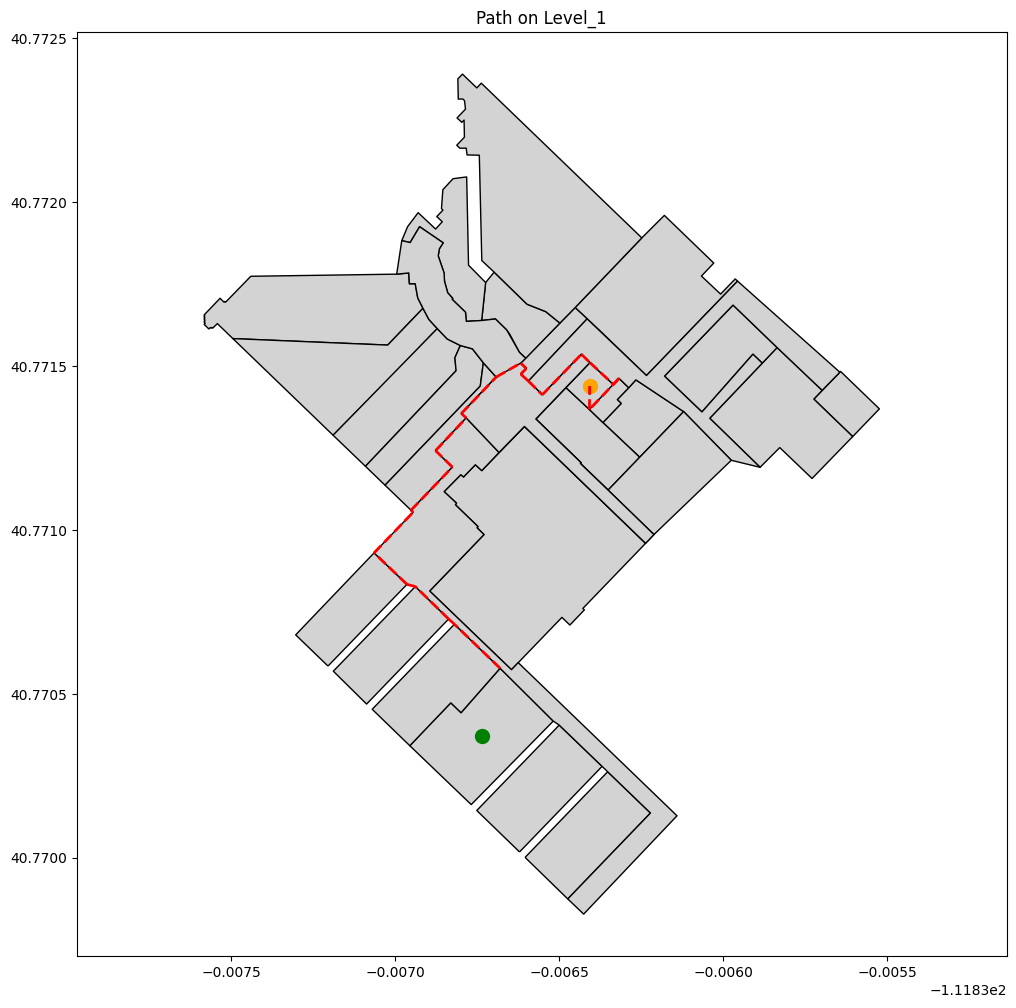

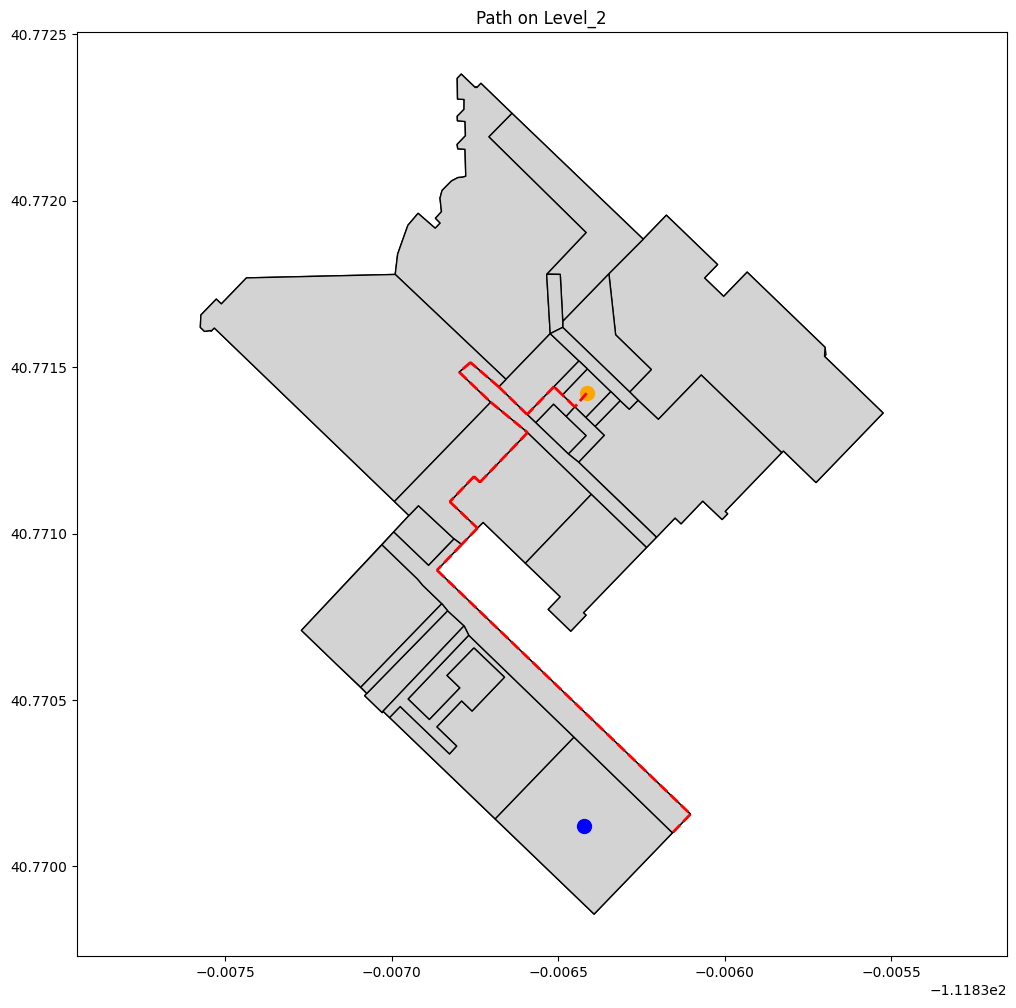

In [16]:
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt

room_type = "Room Type"
room_no = "Room No"

# --- Load GeoJSONs ---
gdf1 = gpd.read_file("Level_1_final_final_final.geojson")
gdf2 = gpd.read_file("Level_2.geojson")

floor_gdfs = {"Level_1": gdf1, "Level_2": gdf2}

# --- Helper functions ---
def build_floor_graph(gdf):
    corridors = gdf[gdf[room_type].str.startswith("c", na=False)].boundary
    G = nx.Graph()
    for geom in corridors:
        if geom.is_empty:
            continue
        if geom.geom_type == "LineString":
            coords = list(geom.coords)
            for i in range(len(coords)-1):
                p1, p2 = Point(coords[i]), Point(coords[i+1])
                G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))
        elif geom.geom_type == "MultiLineString":
            for part in geom.geoms:
                coords = list(part.coords)
                for i in range(len(coords)-1):
                    p1, p2 = Point(coords[i]), Point(coords[i+1])
                    G.add_edge((p1.x, p1.y), (p2.x, p2.y), weight=p1.distance(p2))
    return G

def connect_to_corridor(point, G):
    nearest = None
    min_dist = float("inf")
    for node in G.nodes:
        d = point.distance(Point(node))
        if d < min_dist:
            min_dist = d
            nearest = node
    return nearest

def add_stairs(G, gdf):
    stairs = gdf[gdf[room_type].str.contains("stair", case=False)]
    stair_nodes = []
    for _, row in stairs.iterrows():
        centroid = row.geometry.centroid
        nearest_node = connect_to_corridor(centroid, G)
        if nearest_node:
            G.add_edge((centroid.x, centroid.y), nearest_node, weight=0.5)
        stair_nodes.append((centroid.x, centroid.y))
    return stair_nodes

# --- Build graphs per floor ---
G1 = build_floor_graph(gdf1)
G2 = build_floor_graph(gdf2)
stairs1 = add_stairs(G1, gdf1)
stairs2 = add_stairs(G2, gdf2)

# --- Merge graphs and connect stairs between levels ---
G_all = nx.Graph()
for floor, G in zip(["Level_1", "Level_2"], [G1, G2]):
    for node in G.nodes:
        G_all.add_node((floor, node))
    for u, v, data in G.edges(data=True):
        G_all.add_edge((floor, u), (floor, v), weight=data["weight"])

# Connect stair nodes between Level 1 and Level 2
for s1, s2 in zip(stairs1, stairs2):
    G_all.add_edge(("Level_1", s1), ("Level_2", s2), weight=1.0)

# --- Get start and end rooms ---
start_room = input("Enter starting room name/number: ").strip()
end_room = input("Enter destination room name/number: ").strip()

def find_node(room_name, floor_gdfs, floor_graphs):
    for floor, gdf in floor_gdfs.items():
        rooms = gdf[~gdf[room_type].str.startswith("c", na=False)]
        geom = rooms[(rooms[room_type]==room_name)|(rooms[room_no]==room_name)].geometry
        if not geom.empty:
            return (floor, connect_to_corridor(geom.iloc[0].centroid, floor_graphs[floor])), geom.iloc[0].centroid
    return None, None

floor_graphs = {"Level_1": G1, "Level_2": G2}
start_node, start_centroid = find_node(start_room, floor_gdfs, floor_graphs)
end_node, end_centroid = find_node(end_room, floor_gdfs, floor_graphs)

if start_node is None or end_node is None:
    raise ValueError("Start or end room not found")

# --- Compute shortest path ---
path_nodes = nx.shortest_path(G_all, source=start_node, target=end_node, weight="weight")

# --- Split path per floor ---
floor_paths = {}
current_floor = path_nodes[0][0]
floor_paths[current_floor] = [path_nodes[0][1]]
for f, node in path_nodes[1:]:
    if f != current_floor:
        current_floor = f
        floor_paths[current_floor] = []
    floor_paths[current_floor].append(node)

# --- Plot per floor ---
for floor, nodes in floor_paths.items():
    gdf_floor = floor_gdfs[floor]
    fig, ax = plt.subplots(figsize=(12,12))
    gdf_floor.plot(ax=ax, color="lightgrey", edgecolor="black")
    for i in range(len(nodes)-1):
        line = LineString([nodes[i], nodes[i+1]])
        x, y = line.xy
        ax.plot(x, y, color="red", linewidth=2, linestyle="--")
    # Plot start/end/stairs
    if floor == start_node[0]:
        ax.scatter(start_centroid.x, start_centroid.y, color="green", s=100, label="Start")
    if floor == end_node[0]:
        ax.scatter(end_centroid.x, end_centroid.y, color="blue", s=100, label="End")
    for s in (stairs1 if floor=="Level_1" else stairs2):
        ax.scatter(s[0], s[1], color="orange", s=100, label="Stair")
    plt.title(f"Path on {floor}")
    plt.axis("equal")
    plt.show()
